#Advanced ML: Домашнее задание 1

Датасет давайте возьмём довольно релевантный
реальной жизни; он доступен по следующей ссылке:
https://ourworldindata.org/coronavirus-source-data

1. Скачайте данные в формате csv, выберите из таблицы данные по России, начиная
с 3 марта 2020 г. (в этот момент впервые стало больше 2 заболевших). В качестве
целевой переменной возьмём число случаев заболевания (столбцы total_cases и
new_cases); для упрощения обработки можно заменить в столбце new_cases все
нули на единицы. Для единообразия давайте зафиксируем тренировочный набор в
виде первых 50 отсчётов (дней), начиная с 3 марта; остальные данные можно
использовать в качестве тестового набора (и он даже будет увеличиваться по мере
выполнения задания).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.stats import multivariate_normal
from datetime import date
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings("ignore")

import seaborn as sns

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()

In [2]:
plt.rcParams["figure.figsize"] = (14,6)

In [3]:
# downloading covid data
!wget 'https://covid.ourworldindata.org/data/owid-covid-data.csv'

--2022-03-07 05:03:37--  https://covid.ourworldindata.org/data/owid-covid-data.csv
Resolving covid.ourworldindata.org (covid.ourworldindata.org)... 104.21.233.138, 104.21.233.137, 2606:4700:3038::6815:e989, ...
Connecting to covid.ourworldindata.org (covid.ourworldindata.org)|104.21.233.138|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘owid-covid-data.csv.5’

owid-covid-data.csv     [     <=>            ]  45.21M  52.6MB/s    in 0.9s    

2022-03-07 05:03:38 (52.6 MB/s) - ‘owid-covid-data.csv.5’ saved [47406460]



In [4]:
# read COVID data for all countries
all_data = pd.read_csv('owid-covid-data.csv')

# select only needed info
data = all_data[all_data['location'] == 'Russia'].copy()
data = data[['date', 'total_cases', 'new_cases']]
data = data[data['date'] >= '2020-03-03']
data.reset_index(drop=True, inplace=True)

# filling zeros and adding day numbers
data['new_cases'] = np.where(data['new_cases'] == 0, 1., data['new_cases'])
data['days'] = range(data.shape[0])

# saving dataset
# data.to_csv('Russia_dataset.csv', index=False)

print(data.shape)
data.head()

(733, 4)


,date,total_cases,new_cases,days
0,2020-03-03,3.0,1.0,0
1,2020-03-04,3.0,1.0,1
2,2020-03-05,4.0,1.0,2
3,2020-03-06,13.0,9.0,3
4,2020-03-07,13.0,1.0,4


In [5]:
# according to the task, train is first 50 days and test is the rest
train = data.iloc[:50]
test = data.iloc[50:60] # data.iloc[50:70]
train.shape, test.shape

((50, 4), (10, 4))

2. Постройте графики целевых переменных. Вы увидите, что число заболевших
растёт очень быстро, на первый взгляд экспоненциально. Для первого подхода к
снаряду давайте это и используем.

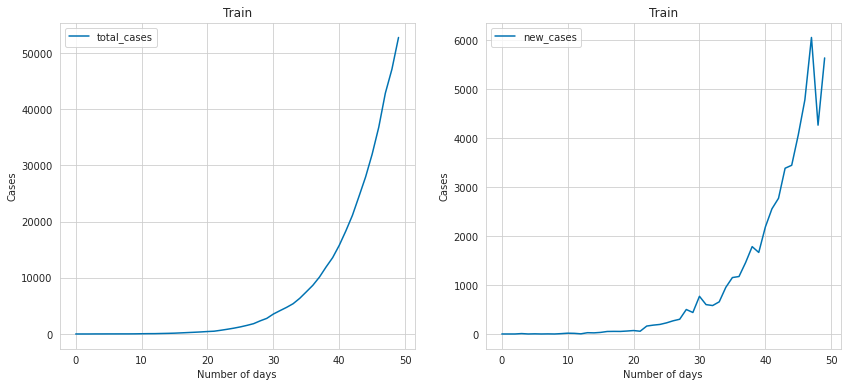

In [6]:
for i, target in enumerate(['total_cases', 'new_cases']):

    plt.subplot(1, 2, i+1)
    plt.title('Train')
    plt.plot(train['days'], train[target], label=target)
    plt.ylabel('Cases')
    plt.xlabel('Number of days')
    plt.legend()

plt.show()

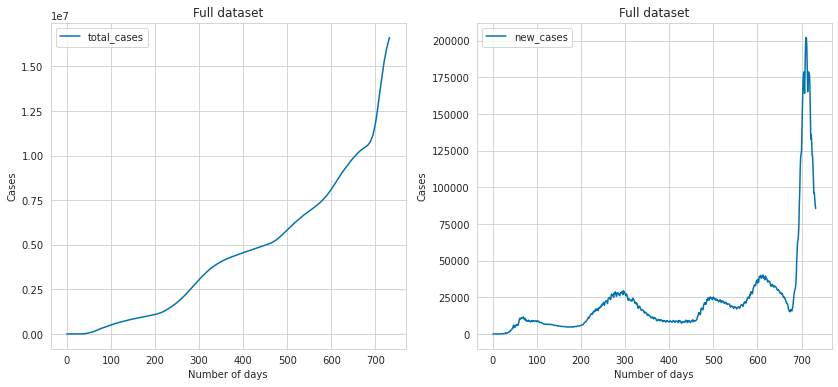

In [7]:
for i, target in enumerate(['total_cases', 'new_cases']):

    plt.subplot(1, 2, i+1)
    plt.title('Full dataset')
    plt.plot(data['days'], data[target], label=target)
    plt.ylabel('Cases')
    plt.xlabel('Number of days')
    plt.legend()

plt.show()

2a. Используя линейную регрессию, обучите модель с экспоненциальным
ростом числа заболевших: y ~ exp(линейная функция от x), где x — номер
текущего дня.

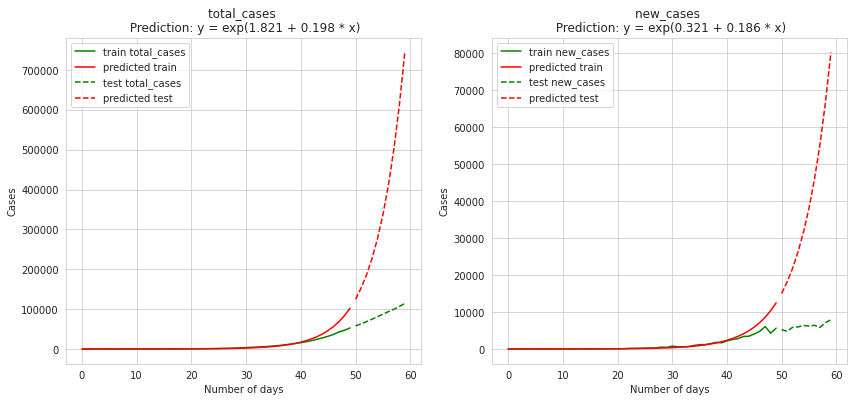

In [8]:
train_predictions = {}
lr_coefs = {}

# plt.figure(figsize=(14,6))

for i, target in enumerate(['total_cases', 'new_cases']):
    lr_exp = LinearRegression()
    lr_exp.fit(train[['days']], np.log(train[target]))

    train_prediction = lr_exp.predict(train[['days']])
    train_predictions[target] = train_prediction
    train_prediction = np.exp(train_prediction)
    test_prediction = np.exp(lr_exp.predict(test[['days']]))

    plt.subplot(1, 2, i+1)
    intercept = lr_exp.intercept_
    coef = lr_exp.coef_[0]
    lr_coefs[target] = {'intercept': intercept, 'coef': coef}

    plt.title(f'{target} \n Prediction: y = exp({round(intercept, 3)} + {round(coef, 3)} * x)')

    plt.plot(train['days'], train[target], label=f'train {target}', c="g")
    plt.plot(train['days'], train_prediction, label=f'predicted train', c="r")
    plt.plot(test['days'], test[target], label=f'test {target}', c="g", linestyle="dashed")
    plt.plot(test['days'], test_prediction, label=f'predicted test', c="r", linestyle="dashed")
    plt.ylabel('Cases')
    plt.xlabel('Number of days')
    plt.legend()

plt.show()

2b. Найдите апостериорное распределение параметров этой модели для
достаточно широкого априорного распределения. Требующееся для этого
значение дисперсии шума в данных оцените, исходя из вашей же
максимальной апостериорной модели (это фактически первый шаг
эмпирического Байеса).

For aposterior distribution of weights:
$$ \Sigma^{-1}_n = \Sigma_{0}^{-1} + \frac{1}{\sigma^2}X^{T}X $$
$$ \overline{\mu}_n = \Sigma_n (\Sigma_{0}^{-1}\overline{\mu}_{0} + \frac{1}{\sigma^2}X^{T}\overline{y}) $$

In [9]:
def bayesian_update(mu, sigma, x, y, sigma_noise=.25):
    x_matrix = np.array([[1, *x]])

    sigma_n = np.linalg.inv(np.linalg.inv(sigma) + (1 / (sigma_noise ** 2)) * (x_matrix.T @ x_matrix))
    mu_n = sigma_n @ ((np.linalg.inv(sigma) @ mu.T) + (1 / (sigma_noise ** 2)) * (x_matrix.T @ np.array([y])))
    
    return mu_n, sigma_n

In [10]:
log_new_cases = np.log(train['new_cases'])
log_total_cases = np.log(train['total_cases'])

sigma_noise_new_cases = np.std(log_new_cases - train_predictions['new_cases'])
sigma_noise_total_cases = np.std(log_total_cases - train_predictions['total_cases'])

print(f'sigma_noise new_cases: {sigma_noise_new_cases}')
print(f'sigma_noise total_cases: {sigma_noise_total_cases}')

sigma_noise new_cases: 0.5960780559466519
sigma_noise total_cases: 0.3490422059635659


In [11]:
def calculate_mu_sigma(x, y, sigma_noise, has_x_squared=False):

    if has_x_squared:
        cur_mu, cur_sigma = np.array([0, 0, 0]), np.array([[1, 0, 0], 
                                                           [0, 1, 0],
                                                           [0, 0, 1]])
    else: 
        cur_mu, cur_sigma = np.array([0, 0]), np.array([[1, 0], [0, 1]])

    # iterate over x and y to find parameters
    for i in range(x.shape[0]):
        px, py = x[i], y[i]
        cur_mu, cur_sigma = bayesian_update(cur_mu, cur_sigma, 
                                            [px], py, 
                                            sigma_noise)
        
    return cur_mu, cur_sigma

def plot_weights_distribution(cur_mu, cur_sigma, plot_limits, 
                              variable_name, N=1000):
    X = np.linspace(*plot_lims[0], N)
    Y = np.linspace(*plot_lims[1], N)
    X, Y = np.meshgrid(X, Y)
    pos = np.empty(X.shape + (2,))
    pos[:, :, 0] = X
    pos[:, :, 1] = Y

    Z = multivariate_normal.pdf(pos, mean=cur_mu, cov=cur_sigma)

    plt.figure(figsize=(8, 8))
    plt.xlim(plot_lims[0])
    plt.ylim(plot_lims[1])
    plt.pcolormesh(X, Y, Z, cmap=plt.cm.jet)
    plt.title(f'Aposterior distribution of weights for {variable_name} model')
    plt.xlabel('Intercept')
    plt.ylabel('Coef')
    plt.show()

Model for new_cases after Bayesian update:
y = exp(0.31222920230908713 + 0.18621776757788344 * x)
Sigma = [[ 2.68473392e-02 -8.13548583e-04]
 [-8.13548583e-04  3.34420329e-05]]


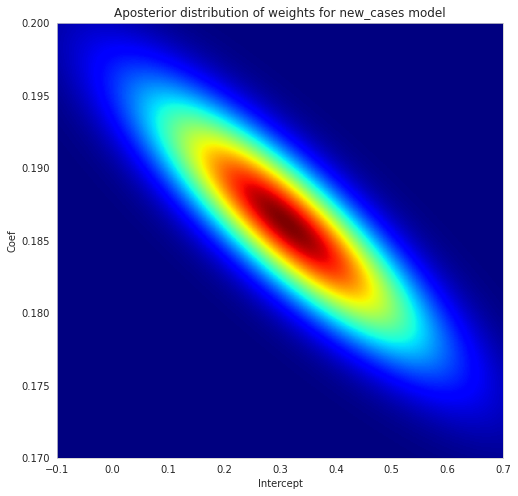

In [12]:
variable_name='new_cases'

cur_mu, cur_sigma = calculate_mu_sigma(train['days'], log_new_cases, 
                                       sigma_noise_new_cases)

print(f'Model for {variable_name} after Bayesian update:')
print(f'y = exp({cur_mu[0]} + {cur_mu[1]} * x)')
print(f'Sigma = {cur_sigma}')

plot_lims = (
    (-0.1, 0.7),
    (0.17, 0.2)
)

plot_weights_distribution(cur_mu, cur_sigma, plot_limits=plot_lims, 
                          variable_name=variable_name)

Model for total_cases for total_cases after Bayesian update:
y = exp(1.8037312430401435 + 0.19880564366436448 * x)
Sigma = [[ 9.37104759e-03 -2.83970283e-04]
 [-2.83970283e-04  1.16188656e-05]]


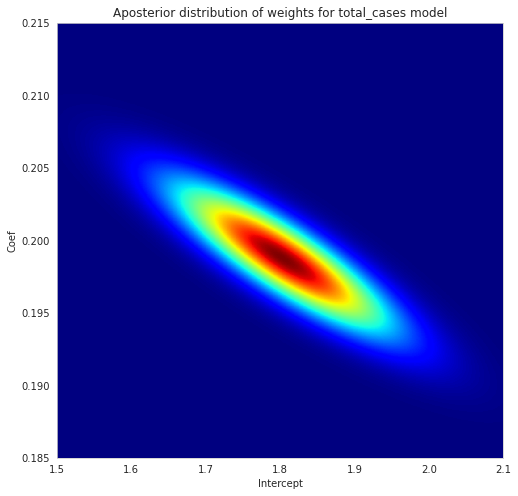

In [13]:
variable_name='total_cases'

cur_mu, cur_sigma = calculate_mu_sigma(train['days'], log_total_cases, 
                                       sigma_noise_total_cases)

print(f'Model for {variable_name} for {variable_name} after Bayesian update:')
print(f'y = exp({cur_mu[0]} + {cur_mu[1]} * x)')
print(f'Sigma = {cur_sigma}')

plot_lims = (
    (1.5, 2.1),
    (0.185, 0.215)
)

plot_weights_distribution(cur_mu, cur_sigma, plot_limits=plot_lims, 
                          variable_name=variable_name)


2c. Посэмплируйте много разных экспонент, постройте графики. Сколько, исходя
из этих сэмплов, предсказывается случаев коронавируса в России к 1 мая? к
1 июня? к 1 сентября? Постройте предсказательные распределения (можно
эмпирически, исходя из данных сэмплирования).

In [14]:
def plot_sample_lines(mu, sigma, n=100, xs=range(190)):
    # sample and visualize 
    my_w = np.random.multivariate_normal(mu, sigma, n)

    plt.title('Predictions')

    for w in my_w:
        plt.plot(xs, np.exp(w[0] + w[1]*xs), 'k-', lw=.4)
        
    plt.xlabel('Number of days')
    plt.ylabel('Total cases')

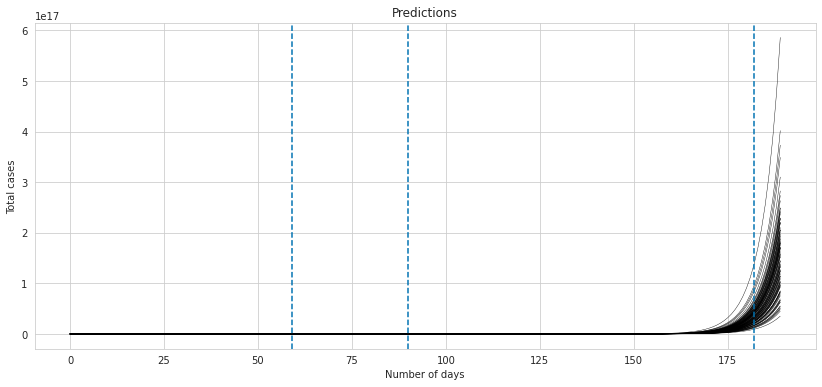

In [15]:
# show predictions for the 1st of May, June and September
# and sample lines with weights taken from the distribution 
plot_sample_lines(cur_mu, cur_sigma)

begin_date = date(2020, 3, 3)
may_1 = (date(2020, 5, 1) - begin_date).days
june_1 = (date(2020, 6, 1) - begin_date).days
september_1 = (date(2020, 9, 1) - begin_date).days

n_days = [may_1, june_1, september_1]

for days in n_days:
    plt.axvline(x=days, linestyle='--')
plt.show()

In [16]:
def get_distribution_by_date(mu, sigma, xs, n=1000):
    my_w = np.random.multivariate_normal(mu, sigma, n)
    res = np.zeros((n, len(xs)))

    for i, w in enumerate(my_w):
        y = np.exp(w[0] + w[1]*xs)
        res[i,:] = y

    return res[:,-1]

may_distribution = get_distribution_by_date(cur_mu, cur_sigma, 
                                            xs=range(may_1))
june_distribution = get_distribution_by_date(cur_mu, cur_sigma, 
                                             xs=range(june_1))
sept_distribution = get_distribution_by_date(cur_mu, cur_sigma, 
                                                  xs=range(september_1))

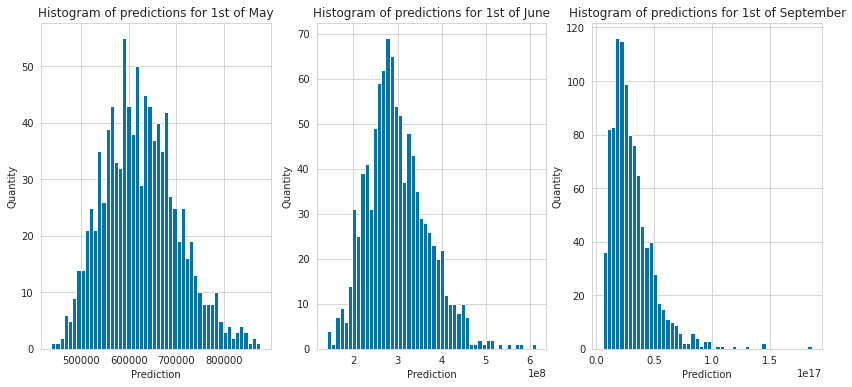

In [17]:
dists = [may_distribution, june_distribution, sept_distribution]
date_labels = ['1st of May', '1st of June', '1st of September']

for i, dist, date in zip(range(3), dists, date_labels):
    plt.subplot(1, 3, i+1)
    plt.title(f'Histogram of predictions for {date}')
    plt.hist(dist, bins=50)
    plt.xlabel('Prediction')
    plt.ylabel('Quantity')

In [18]:
for dist, date in zip(dists, date_labels):
    print(f'Mean prediction for {date}: {np.mean(dist)}')

Mean prediction for 1st of May: 625130.1284725484
Mean prediction for 1st of June: 299043827.6000356
Mean prediction for 1st of September: 3.0536066634871404e+16


It is seen that the prediction with exp for long timeframe are not realistic. Even for June the number of total cases prdicted in Russia is larger than the whole population in Russia. We should find something more realistic.

3. Предсказания экспоненциальной модели наверняка получились грустными. Но это,
конечно, чересчур пессимистично — экспоненциальный рост в природе никак не
может продолжаться вечно. Кривая общего числа заболевших во время эпидемии в
реальности имеет сигмоидальный вид: после начальной фазы экспоненциального
роста неизбежно происходит насыщение. В качестве конкретной формы такой
сигмоиды давайте возьмём форму функции распределения для гауссиана.

Естественно, в нашем случае сигмоида стремится не к единице, т.е. константа
перед интегралом может быть произвольной (и её можно внести в экспоненту), а в
экспоненте под интегралом может быть произвольная квадратичная функция от t.

3a. Предложите способ обучать параметры такой сигмоидальной функции при
помощи линейной регрессии.

Gaussian probability density function:
${\displaystyle {\frac {c}{\sigma {\sqrt {2\pi }}}}\;\exp \left(-{\frac {\left(x-\mu \right)^{2}}{2\sigma ^{2}}}\right)}$. 

We can model new cases using it. For example, with linear regression:
$ln y = ln c - ln \sigma \sqrt {2\pi} - \frac {(x - \mu)^2}{2\sigma ^2} = ln c - ln \sigma \sqrt {2\pi} - \frac {x^2}{2\sigma ^2} + \frac {x\mu}{\sigma^2} - \frac {\mu^2}{2\sigma^2} = ax^2 + bx + c$ 

By modeling this way we'll be able to model total cases with sigmoid as a cumulative sum of new cases.

3b. Обучите эти параметры на датасете случаев коронавируса в России.
Найдите апостериорное распределение параметров этой модели для
достаточно широкого априорного распределения. Требующееся для этого
значение дисперсии шума в данных оцените, исходя из вашей же
максимальной апостериорной модели.

In [19]:
train['x'] = train['days']
train['x_sq'] = np.power(train['days'], 2)
train['y_new_cases'] = np.log(train['new_cases'])

test = data.iloc[50:, :]
test['x'] = test['days']
test['x_sq'] = np.power(test['days'], 2)
test['y_new_cases'] = np.log(test['new_cases'])

In [20]:
lr = LinearRegression()

lr.fit(train[['x', 'x_sq']], train['y_new_cases'])

preds_log_new_cases_train = lr.predict(train[['x', 'x_sq']])
preds_new_cases_train = np.exp(preds_log_new_cases_train)

preds_log_new_cases_test = lr.predict(test[['x', 'x_sq']])
preds_new_cases_test = np.exp(preds_log_new_cases_test)

preds_total_cases_train = np.cumsum(preds_new_cases_train)
preds_total_cases_test = np.cumsum(np.concatenate([preds_new_cases_train, 
                                                   preds_new_cases_test]))[50:]

preds_log_train_total_cases = np.log(preds_total_cases_train)
preds_log_test_total_cases = np.log(preds_total_cases_test)

print('Predicted model by Linear Regression (MAP):')
print(f'log(new cases) = {lr.coef_[1]} * x^2 + {lr.coef_[0]} * x {lr.intercept_}')

Predicted model by Linear Regression (MAP):
log(new cases) = -0.0018297906166869166 * x^2 + 0.27562283190276415 * x -0.3965904028416256


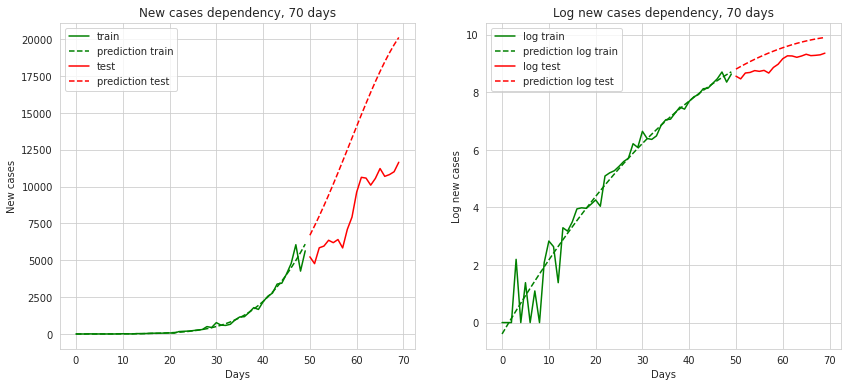

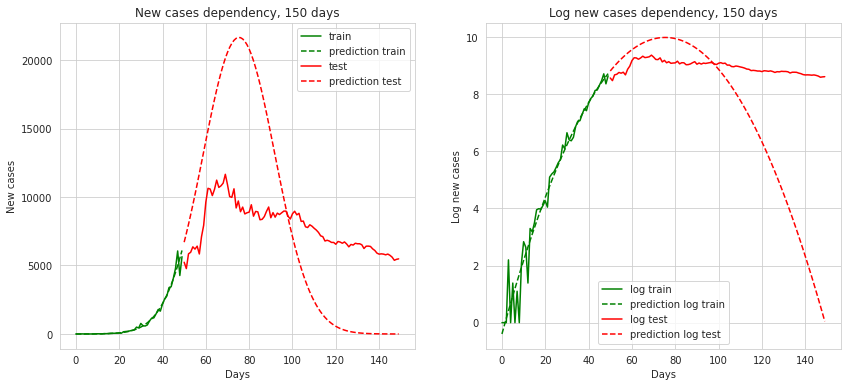

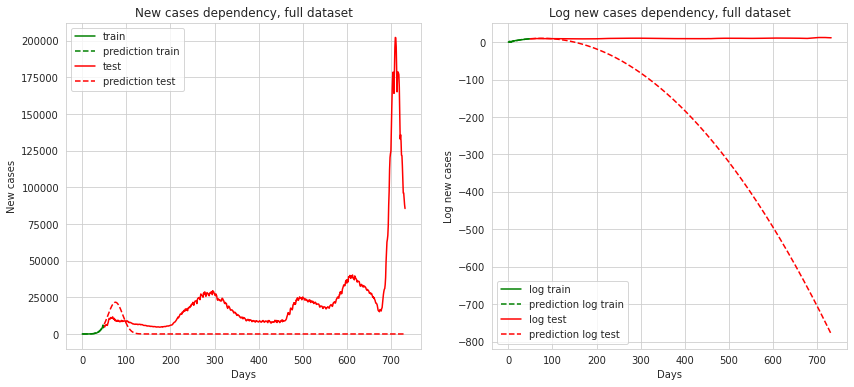

In [21]:
for days_max, label in zip([20, 100, 800], ['70 days', '150 days', 'full dataset']):

    plt.subplot(1, 2, 1)

    plt.title(f'New cases dependency, {label}')
    plt.plot(train['days'], train['new_cases'], 
            label='train', c='g')
    plt.plot(train['days'], preds_new_cases_train, 
            label='prediction train', c='g', linestyle="dashed")

    plt.plot(test['days'][:days_max], test['new_cases'][:days_max], 
            label='test', c='r')
    plt.plot(test['days'][:days_max], preds_new_cases_test[:days_max], 
            label='prediction test', c='r', linestyle="dashed")

    plt.ylabel('New cases')
    plt.xlabel('Days')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.title(f'Log new cases dependency, {label}')
    plt.plot(train['days'], train['y_new_cases'], 
            label='log train', c='g')
    plt.plot(train['days'], preds_log_new_cases_train, 
            label='prediction log train', c='g', linestyle="dashed")

    plt.plot(test['days'][:days_max], test['y_new_cases'][:days_max], 
            label='log test', c='r')
    plt.plot(test['days'][:days_max], preds_log_new_cases_test[:days_max], 
            label='prediction log test', c='r', linestyle="dashed")

    plt.ylabel('Log new cases')
    plt.xlabel('Days')
    plt.legend()

    plt.show()

It is seen that there are several COVID waves which should be evaluated with different models.

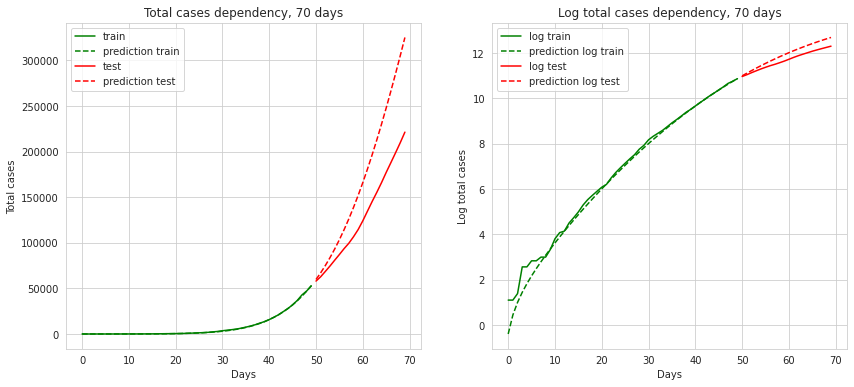

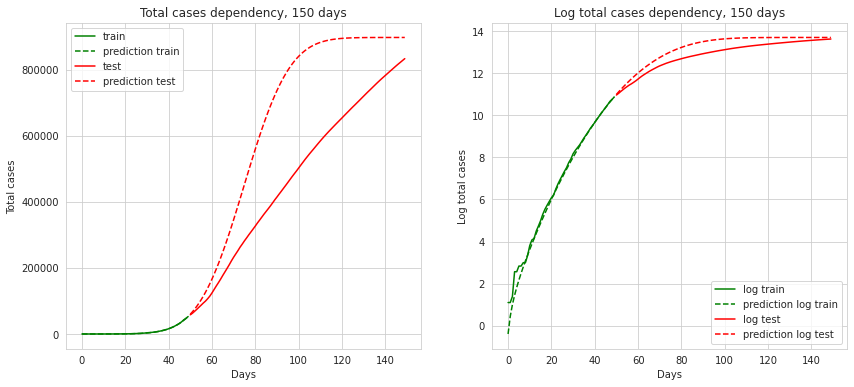

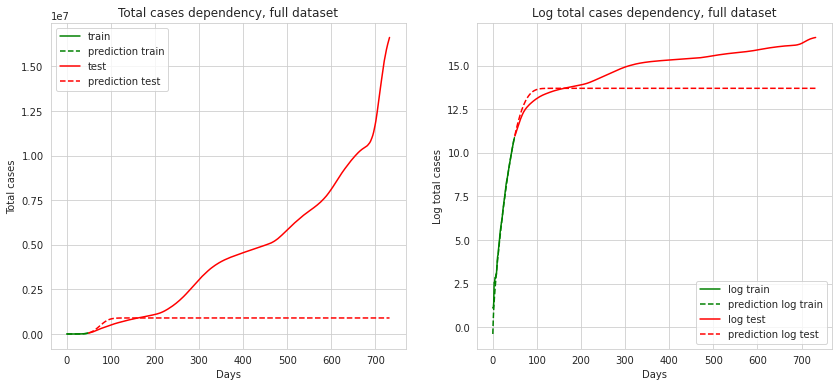

In [22]:
for days_max, label in zip([20, 100, 800], ['70 days', '150 days', 'full dataset']):
    plt.subplot(1, 2, 1)

    plt.title(f'Total cases dependency, {label}')
    plt.plot(train['days'], train['total_cases'], 
            label='train', c='g')
    plt.plot(train['days'], preds_total_cases_train, 
            label='prediction train', c='g', linestyle='dashed')

    plt.plot(test['days'][:days_max], test['total_cases'][:days_max], 
            label='test', c='r')
    plt.plot(test['days'][:days_max], preds_total_cases_test[:days_max], 
            label='prediction test', c='r', linestyle='dashed')

    plt.ylabel('Total cases')
    plt.xlabel('Days')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.title(f'Log total cases dependency, {label}')
    plt.plot(train['days'], log_total_cases, 
            label='log train', c='g')
    plt.plot(train['days'], preds_log_train_total_cases, 
            label='prediction log train', c='g', linestyle='dashed')

    plt.plot(test['days'][:days_max], np.log(test['total_cases'])[:days_max], 
            label='log test', c='r')
    plt.plot(test['days'][:days_max], preds_log_test_total_cases[:days_max], 
            label='prediction log test', c='r', linestyle='dashed')

    plt.ylabel('Log total cases')
    plt.xlabel('Days')
    plt.legend()

    plt.show()

In [23]:
sigma_noise = np.std(log_new_cases - preds_log_new_cases_train)

print(f'sigma_noise: {sigma_noise}')

sigma_noise: 0.4891695424595194


In [24]:
cur_mu, cur_sigma = np.array([0, 0, 0]), np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])

x_train = np.array(train[['x', 'x_sq']])

for i in range(50):
    px, py = x_train[i], log_new_cases[i]
    cur_mu, cur_sigma = bayesian_update(cur_mu, cur_sigma, px, py, sigma_noise)

print(f'Model after Bayesian update:')
print(f'log(new cases) = {cur_mu[2]} * x^2 + {cur_mu[1]} * x {cur_mu[0]}\n')
print(f'Sigma = {cur_sigma}')

Model after Bayesian update:
log(new cases) = -0.001807331567864695 * x^2 + 0.2743017682862252 * x -0.38056121936728005

Sigma = [[ 3.82686360e-02 -3.09159617e-03  5.20446055e-05]
 [-3.09159617e-03  3.44507643e-04 -6.59745890e-06]
 [ 5.20446055e-05 -6.59745890e-06  1.35243124e-07]]


3c. Посэмплируйте много разных сигмоид из апостериорного распределения,
постройте графики. Сколько, исходя из этих сэмплов, будет всего случаев
коронавируса в России? Постройте эмпирическое предсказательное
распределение, нарисуйте графики. Каков ваш прогноз числа случаев
коронавируса в пессимистичном сценарии (90-й процентиль в выборке
числа случаев)? В оптимистичном сценарии (10-й процентиль)?

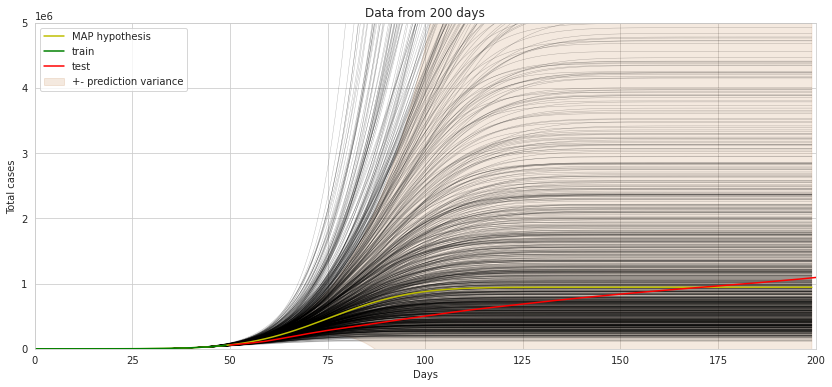

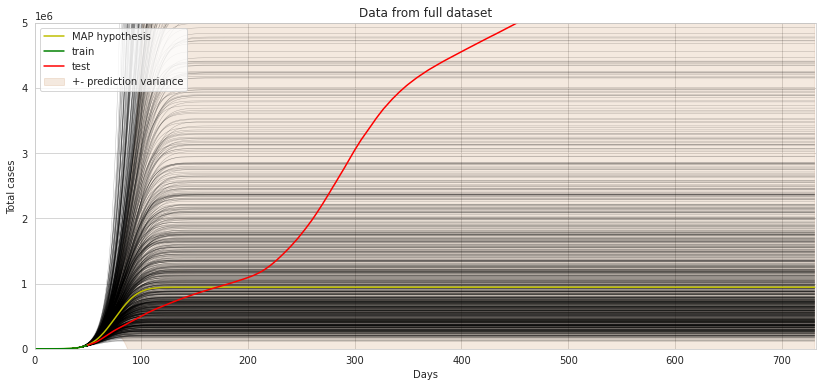

In [25]:
N = 1000

my_w = np.random.multivariate_normal(cur_mu, cur_sigma, N)


for n_days, label in zip([200, max(data['days'])], 
                         ['200 days', 'full dataset']):
  
    res = np.zeros((N, n_days))
    x = np.array(range(n_days))
    x_sq = np.power(x, 2)

    plt.title(f'Data from {label}')

    for i, w in enumerate(my_w):
        y = np.cumsum(np.exp(w[0] + w[1]*x + w[2]*x_sq))
        plt.plot(x, y, 'k-', lw=.4, alpha=0.3)
        res[i,:] = y

    prediction = np.cumsum(np.exp(cur_mu[2]*x_sq + cur_mu[1]*x + cur_mu[0]))
    plt.plot(x[:n_days], prediction[:n_days], color='y', label='MAP hypothesis')

    plt.plot(train['days'], train['total_cases'], 
                label='train', c='g')

    plt.plot(test['days'][:n_days], test['total_cases'][:n_days], 
            label='test', c='r')    

    plt.fill_between(x, np.mean(res, axis=0) - np.std(res, axis=0), 
                    np.mean(res, axis=0) + np.std(res, axis=0), 
                    color=palette[5], alpha=.2, label='+- prediction variance')

    plt.ylabel('Total cases')
    plt.xlabel('Days')

    plt.ylim((0, 5e6))
    plt.xlim((0, n_days))
    plt.legend()
    plt.show()

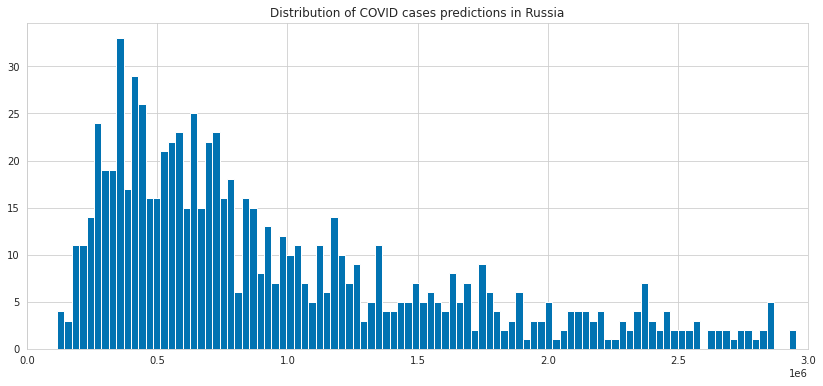

Pessimistic scenario prediction: 6270466.432515276
Optimistic scenario prediction: 332521.15810272284


In [26]:
dist = res[:,-1]

plt.title('Distribution of COVID cases predictions in Russia')
plt.hist(dist[dist < 3e6], bins=100)
plt.xlim((0, 3e6))
plt.show()

print(f'Pessimistic scenario prediction: {np.percentile(dist, 90)}')
print(f'Optimistic scenario prediction: {np.percentile(dist, 10)}')

4. Бонус: проведите такой же анализ для других стран (здесь придётся руками
подобрать дни начала моделирования — коронавирус приходил в разные страны в
разное время). Насколько разные параметры получаются? Можно ли разделить
страны на кластеры (хотя бы чисто визуально) в зависимости от этих параметров?

In [27]:
country_to_start_date = {
    
    'Finland': '2020-02-28',
    'Norway': '2020-02-16',
    'United Kingdom': '2020-02-19',
    'Sweden': '2020-02-26',

    'France': '2020-02-14',
    'Germany': '2020-02-19',
    'Spain': '2020-02-23',
    'Italy': '2020-02-19',
    'Greece': '2020-02-28',
    
    'Belarus': '2020-03-18',
    'Ukraine': '2020-03-13',
    'Poland': '2020-03-04',

    'United States': '2020-02-21',
    'Canada': '2020-02-27',
    'Mexico': '2020-03-10',

    'Argentina': '2020-03-13',
    'Brazil': '2020-03-10',
    'Peru': '2020-03-10',
    'Ecuador': '2020-03-03',
    'Chile': '2020-03-10',

    'Australia': '2020-02-25',
    'United Arab Emirates': '2020-03-04',
    'India': '2020-03-03',
    'Japan': '2020-02-10',
}

# this is from further analysis 
# just to make plot comparision easier
order = [# cluster_0
         'United Arab Emirates', 'Ecuador', 'Canada', 'Ukraine','Belarus', 
         'Poland', 'Finland', 'France', 'Sweden', 'United Kingdom',
        # cluster_1
         'Spain', 'Italy', 'Australia', 'United States', 'Germany', 'Norway',
        # cluster_2
         'Chile', 'Mexico', 'Brazil', 'Argentina', 'India', 'Greece', 'Peru',
         'Japan']

In [28]:
# ylim parameters for nicer graphs
country_to_ylim = {'France': 5e6, 'Greece': 5e5, 'Belarus': 5e5, 
                   'United States': 5e6, 'Argentina': 5e5, 'Brazil': 5e5,
                   'Peru': 5e6, 'Ecuador': 5e4, 'Chile': 5e4,
                   'United Arab Emirates': 5e6, 'India': 5e6, 'Japan': 6e4}

Cluster 0

 ############################## United Arab Emirates ##############################
Model after Bayesian update:
log(new cases) = -0.001436820281783588 * x^2 + 0.2019360550285132 * x + -0.25624790283067256



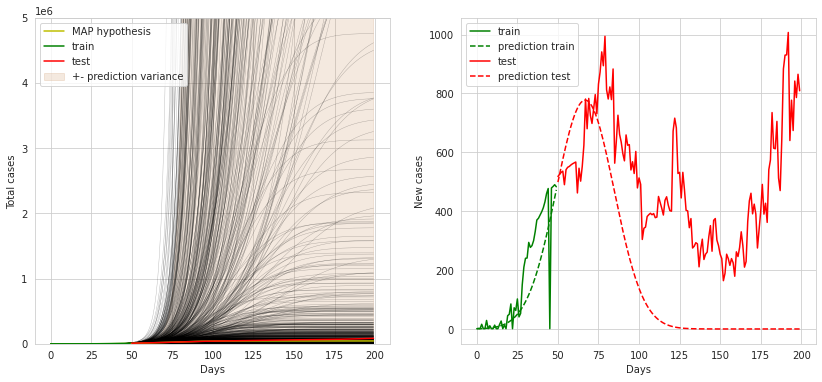


 ############################## Ecuador ##############################
Model after Bayesian update:
log(new cases) = -0.0037061477706062107 * x^2 + 0.30468505736743534 * x + -0.6214608606115846



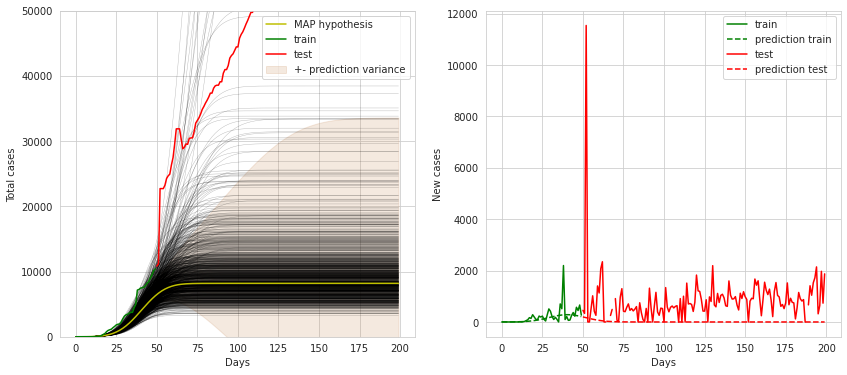


 ############################## Canada ##############################
Model after Bayesian update:
log(new cases) = -0.0034737325028416643 * x^2 + 0.30796776617592325 * x + 0.5909594463681529



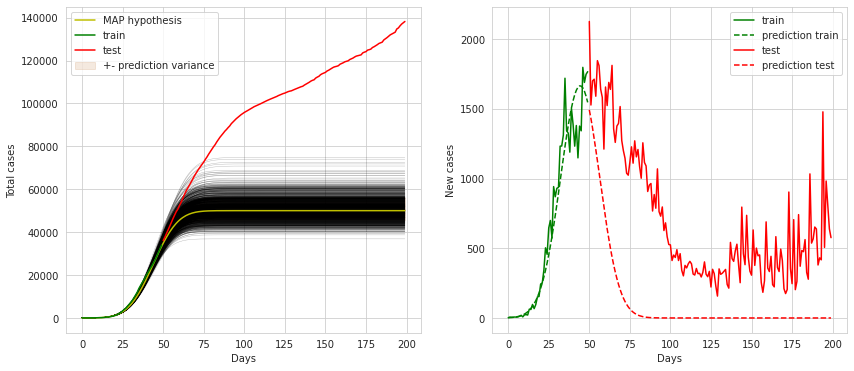


 ############################## Ukraine ##############################
Model after Bayesian update:
log(new cases) = -0.0035138227116637277 * x^2 + 0.29083444852654683 * x + 0.1271535080410331



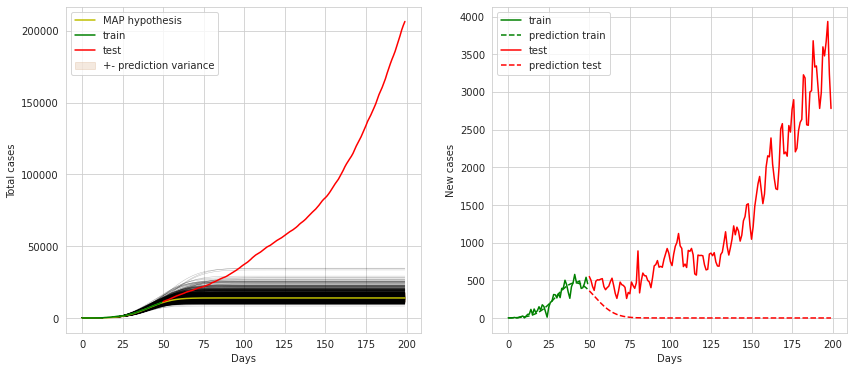


 ############################## Belarus ##############################
Model after Bayesian update:
log(new cases) = -0.003064254841874392 * x^2 + 0.29359197165295825 * x + -0.06951722800150861



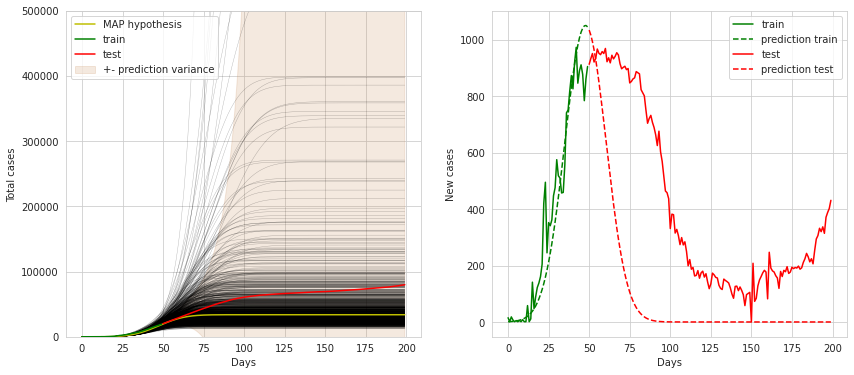


 ############################## Poland ##############################
Model after Bayesian update:
log(new cases) = -0.0042819455420941566 * x^2 + 0.3168932619733891 * x + 0.20598450471268848



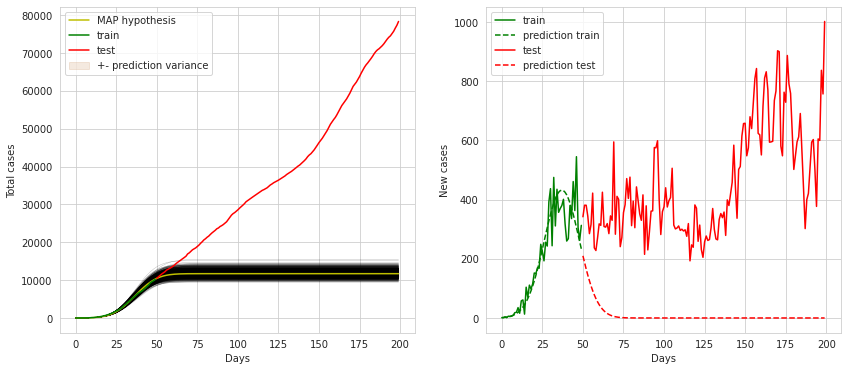


 ############################## Finland ##############################
Model after Bayesian update:
log(new cases) = -0.004035852635224144 * x^2 + 0.28859740445601645 * x + -0.09807718831353895



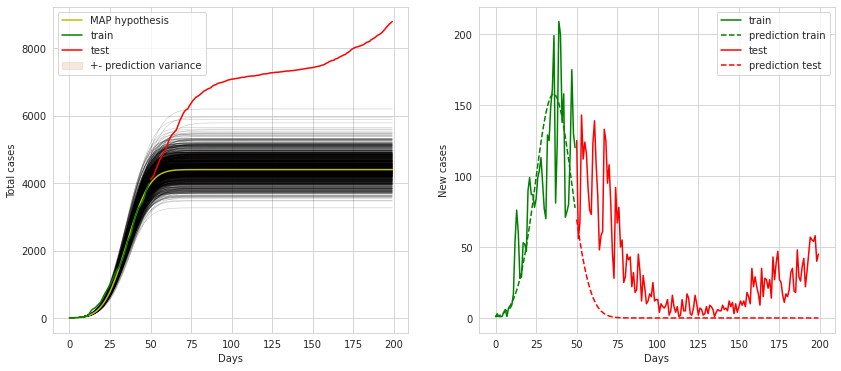


 ############################## France ##############################
Model after Bayesian update:
log(new cases) = -0.0020174970622059973 * x^2 + 0.30353379175881123 * x + -1.0997495294905875



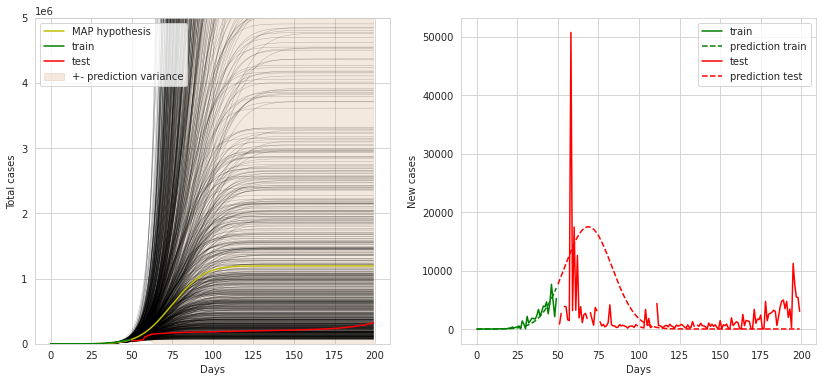


 ############################## Sweden ##############################
Model after Bayesian update:
log(new cases) = -0.003663394897457234 * x^2 + 0.2847690418190254 * x + 0.7184392147204761



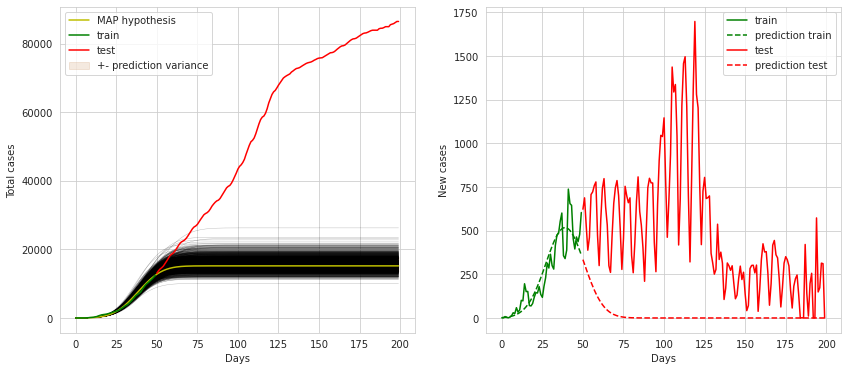


 ############################## United Kingdom ##############################
Model after Bayesian update:
log(new cases) = -0.0035193026439947483 * x^2 + 0.3586221223403818 * x + -0.49376749487781524



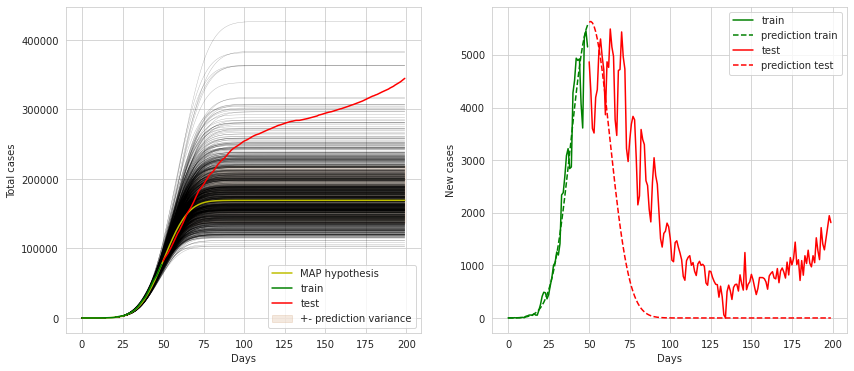

Cluster 1

 ############################## Spain ##############################
Model after Bayesian update:
log(new cases) = -0.005875291667640503 * x^2 + 0.4579350189635498 * x + 0.0016403658754171602



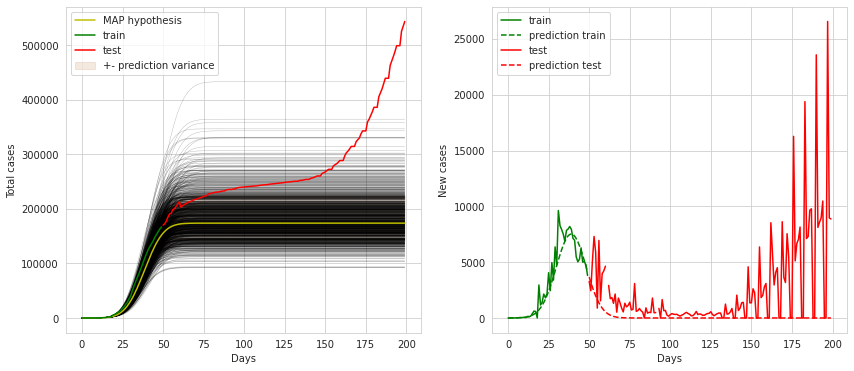


 ############################## Italy ##############################
Model after Bayesian update:
log(new cases) = -0.005789781335075517 * x^2 + 0.40378831359404366 * x + 1.7880490234766881



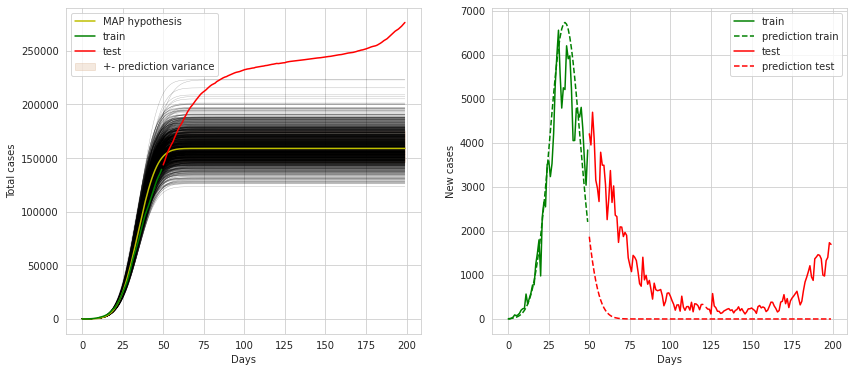


 ############################## Australia ##############################
Model after Bayesian update:
log(new cases) = -0.005569165574971641 * x^2 + 0.36850556336318263 * x + -0.7731433147827218



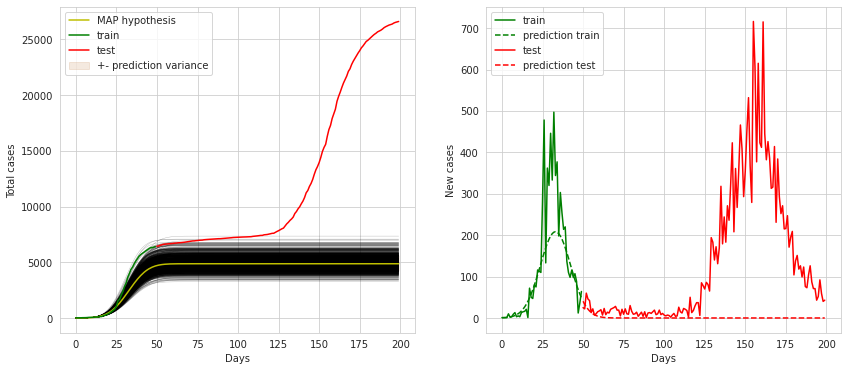


 ############################## United States ##############################
Model after Bayesian update:
log(new cases) = -0.004315028379445696 * x^2 + 0.4589106274297947 * x + -1.3173356522039086



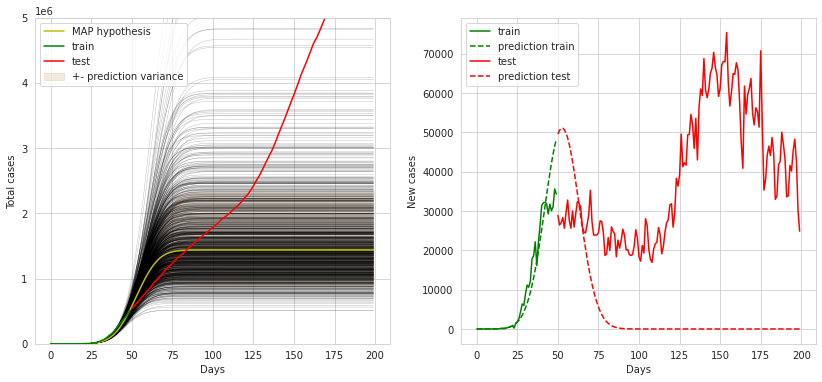


 ############################## Germany ##############################
Model after Bayesian update:
log(new cases) = -0.005414398650762764 * x^2 + 0.460914787074854 * x + -1.1364086380124405



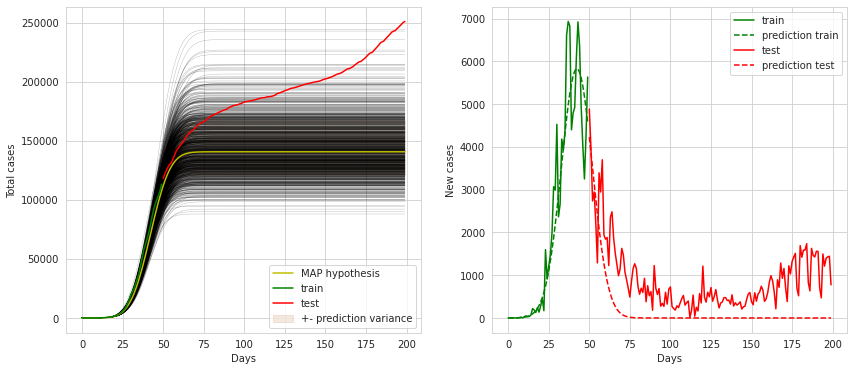


 ############################## Norway ##############################
Model after Bayesian update:
log(new cases) = -0.005864240675483287 * x^2 + 0.34478012088557275 * x + 0.5301459412312894



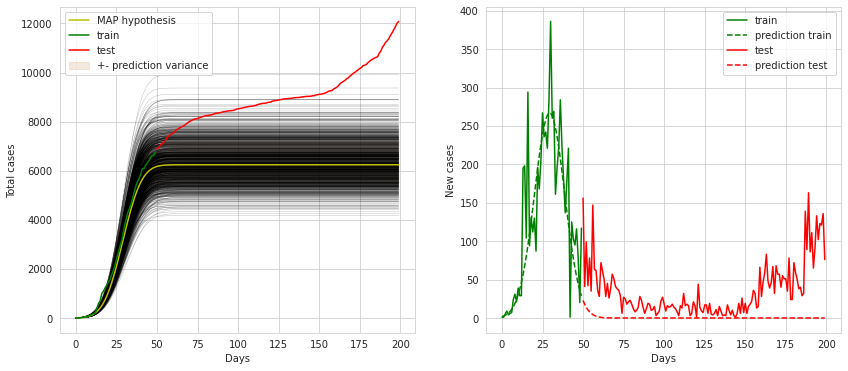

Cluster 2

 ############################## Chile ##############################
Model after Bayesian update:
log(new cases) = -0.0036356115714338832 * x^2 + 0.26349924353488774 * x + 1.6386817008324357



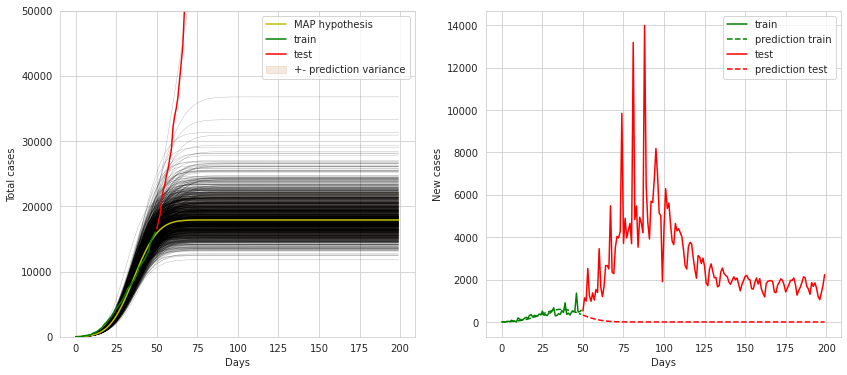


 ############################## Mexico ##############################
Model after Bayesian update:
log(new cases) = -0.002467600403418785 * x^2 + 0.2328836630053841 * x + 1.2114152360118737



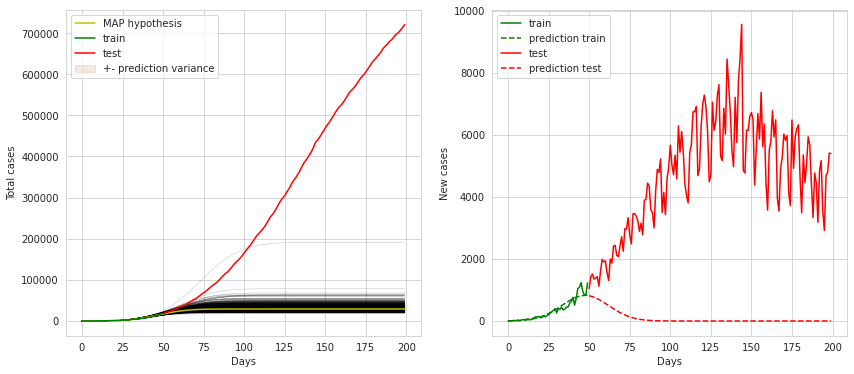


 ############################## Brazil ##############################
Model after Bayesian update:
log(new cases) = -0.0034207627720047873 * x^2 + 0.28851650062514267 * x + 2.007818760491759



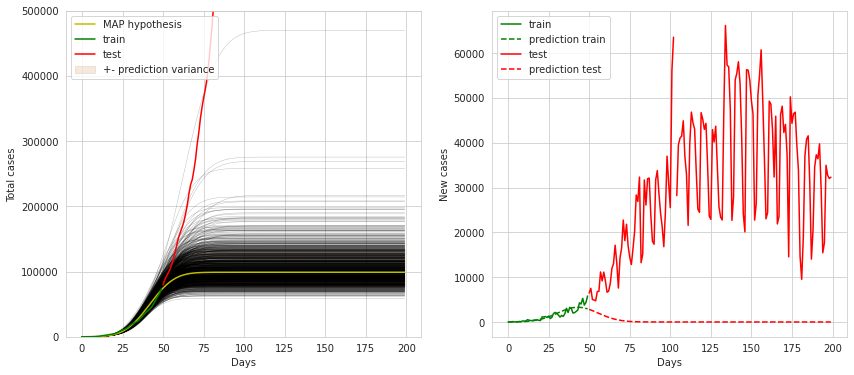


 ############################## Argentina ##############################
Model after Bayesian update:
log(new cases) = -0.0013933110156462841 * x^2 + 0.12749940575829388 * x + 1.871381957733817



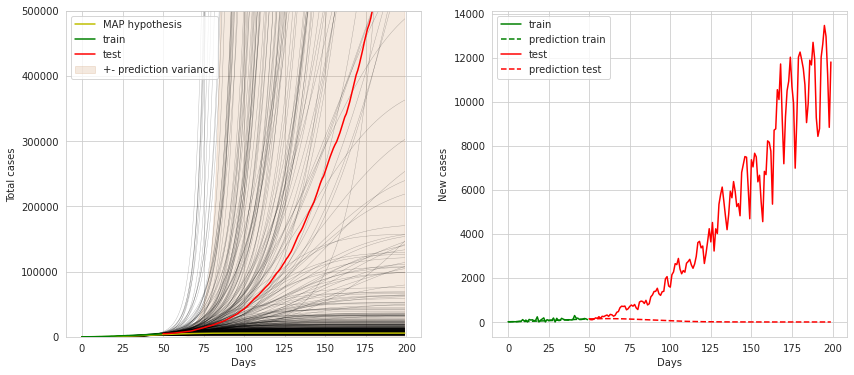


 ############################## India ##############################
Model after Bayesian update:
log(new cases) = -0.0013429259665568294 * x^2 + 0.20874043415020171 * x + 0.47789929519400687



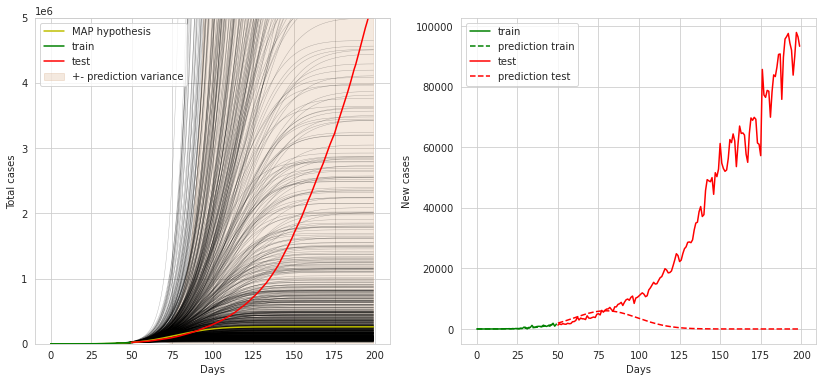


 ############################## Greece ##############################
Model after Bayesian update:
log(new cases) = -0.002041685886363949 * x^2 + 0.14961138244175798 * x + 0.38394329705827346



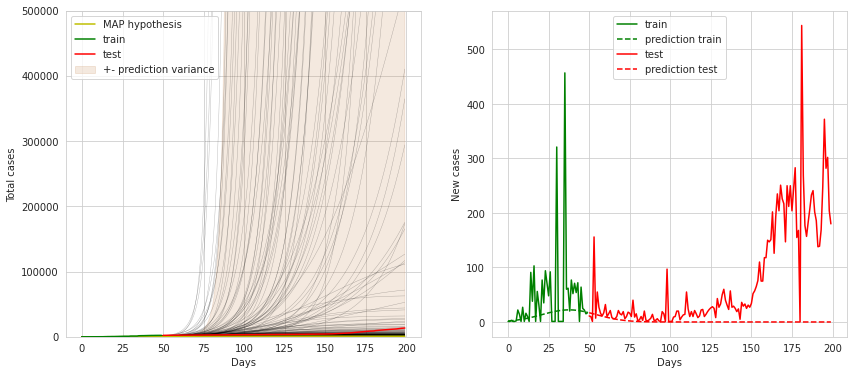


 ############################## Peru ##############################
Model after Bayesian update:
log(new cases) = -0.0020901345930255666 * x^2 + 0.23624854427349984 * x + 1.0237601971241475



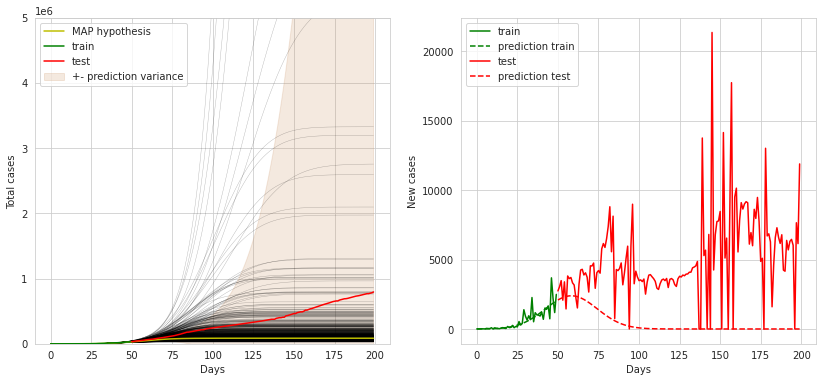


 ############################## Japan ##############################
Model after Bayesian update:
log(new cases) = -0.0010471987107780883 * x^2 + 0.12186826117787852 * x + 1.015160220481178



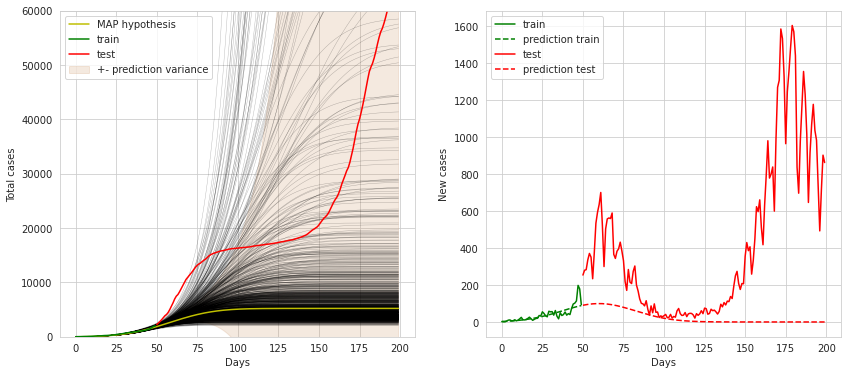

In [29]:
TRAIN_SIZE = 50
ALL_SIZE = 200
N = 1000
n_days = ALL_SIZE

stat_dict = {'country': ['Russia'],
             'x_sq_coef': [cur_mu[2]],
             'x_coef': [cur_mu[1]],
             'intersept': [cur_mu[0]]}

for location in order: #list(country_to_start_date.keys()):
    # based on further research
    if location == 'United Arab Emirates' :
        print('Cluster 0')
    if location == 'Spain' :
        print('Cluster 1')
    if location == 'Chile' :
        print('Cluster 2')

    print('\n', '#'*30, location, '#'*30)
    stat_dict['country'].append(location)

    # preparing country dataset
    country_data = all_data[['total_cases', 'new_cases', 'date']][all_data['location']==location].copy()
    country_data = country_data[country_data['date'] >= country_to_start_date[location]]
    country_data.reset_index(drop=True, inplace=True)
    country_data['new_cases'] = np.where(country_data['new_cases'] == 0, 1., country_data['new_cases'])
    days = range(country_data.shape[0])

    train = pd.DataFrame()
    train['x'] = days[:TRAIN_SIZE]
    train['x_sq'] = np.power(train['x'], 2)
    train['y_new_cases'] = np.log(country_data['new_cases'][:TRAIN_SIZE].values)
    train['new_cases'] = country_data['new_cases'][:TRAIN_SIZE].values
    train['total_cases'] = country_data['total_cases'][:TRAIN_SIZE].values
    log_new_cases = train['y_new_cases']

    test = pd.DataFrame()
    test['x'] = days[TRAIN_SIZE:ALL_SIZE]
    test['x_sq'] = np.power(test['x'], 2)
    test['y_new_cases'] = np.log(country_data['new_cases'][TRAIN_SIZE:ALL_SIZE].values)
    test['new_cases'] = country_data['new_cases'][TRAIN_SIZE:ALL_SIZE].values
    test['total_cases'] = country_data['total_cases'][TRAIN_SIZE:ALL_SIZE].values


    # finding Linear Regression Parameters
    lr = LinearRegression()

    lr.fit(train[['x', 'x_sq']], train['y_new_cases'])

    preds_log_new_cases_train = lr.predict(train[['x', 'x_sq']])
    preds_new_cases_train = np.exp(preds_log_new_cases_train)

    preds_log_new_cases_test = lr.predict(test[['x', 'x_sq']])
    preds_new_cases_test = np.exp(preds_log_new_cases_test)

    preds_total_cases_train = np.cumsum(preds_new_cases_train)
    preds_total_cases_test = np.cumsum(np.concatenate([preds_new_cases_train, 
                                                      preds_new_cases_test]))[TRAIN_SIZE:]

    preds_log_train_total_cases = np.log(preds_total_cases_train)
    preds_log_test_total_cases = np.log(preds_total_cases_test)


    # Bayesian update
    sigma_noise = np.std(log_new_cases - preds_log_new_cases_train)

    cur_mu, cur_sigma = np.array([0, 0, 0]), np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])

    x_train = np.array(train[['x', 'x_sq']])

    for i in range(50):
        px, py = x_train[i], log_new_cases[i]
        cur_mu, cur_sigma = bayesian_update(cur_mu, cur_sigma, px, py, sigma_noise)

    print(f'Model after Bayesian update:')
    print(f'log(new cases) = {cur_mu[2]} * x^2 + {cur_mu[1]} * x + {cur_mu[0]}\n')

    stat_dict['x_sq_coef'].append(cur_mu[2])
    stat_dict['x_coef'].append(cur_mu[1])
    stat_dict['intersept'].append(cur_mu[0])

   
    # sampling and building a plot
    my_w = np.random.multivariate_normal(cur_mu, cur_sigma, N)
  
    res = np.zeros((N, n_days))
    x = np.array(range(n_days))
    x_sq = np.power(x, 2)

    plt.subplot(1, 2, 1)    

    for i, w in enumerate(my_w):
        y = np.cumsum(np.exp(w[0] + w[1]*x + w[2]*x_sq))
        plt.plot(x, y, 'k-', lw=.4, alpha=0.3)
        res[i,:] = y

    prediction = np.cumsum(np.exp(cur_mu[2]*x_sq + cur_mu[1]*x + cur_mu[0]))
    plt.plot(x[:n_days], prediction[:n_days], color='y', label='MAP hypothesis')

    plt.plot(train['x'], train['total_cases'], 
                label='train', c='g')

    plt.plot(test['x'], test['total_cases'], 
            label='test', c='r')    

    plt.fill_between(x, np.mean(res, axis=0) - np.std(res, axis=0), 
                    np.mean(res, axis=0) + np.std(res, axis=0), 
                    color=palette[5], alpha=.2, label='+- prediction variance')

    plt.ylabel('Total cases')
    plt.xlabel('Days')

    if location in country_to_ylim:
        ylim = country_to_ylim[location]
        plt.ylim((0, ylim))

    plt.legend()

    plt.subplot(1, 2, 2)

    plt.plot(train['x'], train['new_cases'], 
            label='train', c='g')
    plt.plot(train['x'], preds_new_cases_train, 
            label='prediction train', c='g', linestyle="dashed")

    plt.plot(test['x'], test['new_cases'], 
            label='test', c='r')
    plt.plot(test['x'], preds_new_cases_test, 
            label='prediction test', c='r', linestyle="dashed")

    plt.ylabel('New cases')
    plt.xlabel('Days')
    plt.legend()
    plt.show()

In [30]:
coefs = pd.DataFrame(data=stat_dict)

# normalization for clustering
c = coefs.drop('country', axis=1).copy()
c['x_sq_coef'] = (c['x_sq_coef'] - np.mean(c['x_sq_coef'])) / np.std(c['x_sq_coef'])
c['x_coef'] = (c['x_coef'] - np.mean(c['x_coef'])) / np.std(c['x_coef'])
c['intersept'] = (c['intersept'] - np.mean(c['intersept'])) / np.std(c['intersept'])

k_means = KMeans(n_clusters=3, random_state=5).fit(c)
coefs['cluster'] = k_means.labels_
coefs.sort_values('cluster', inplace=True)
coefs

,country,x_sq_coef,x_coef,intersept,cluster
12,Italy,-0.005790,0.403788,1.788049,0
16,Norway,-0.005864,0.344780,0.530146,0
15,Germany,-0.005414,0.460915,-1.136409,0
14,United States,-0.004315,0.458911,-1.317336,0
13,Australia,-0.005569,0.368506,-0.773143,0
11,Spain,-0.005875,0.457935,0.001640,0
22,Greece,-0.002042,0.149611,0.383943,1
21,India,-0.001343,0.208740,0.477899,1
20,Argentina,-0.001393,0.127499,1.871382,1
19,Brazil,-0.003421,0.288517,2.007819,1


No handles with labels found to put in legend.


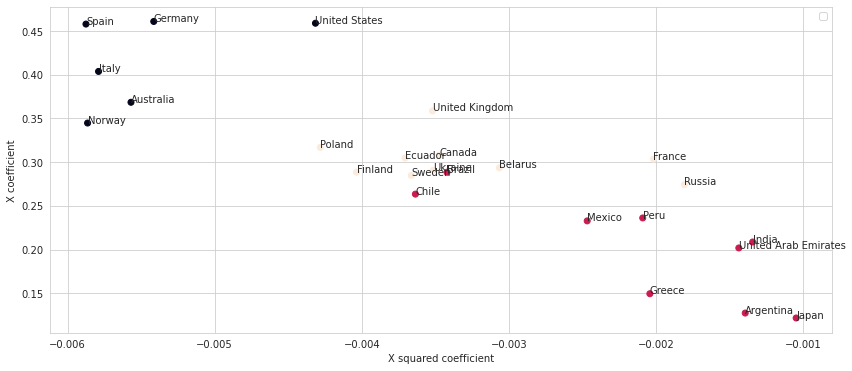

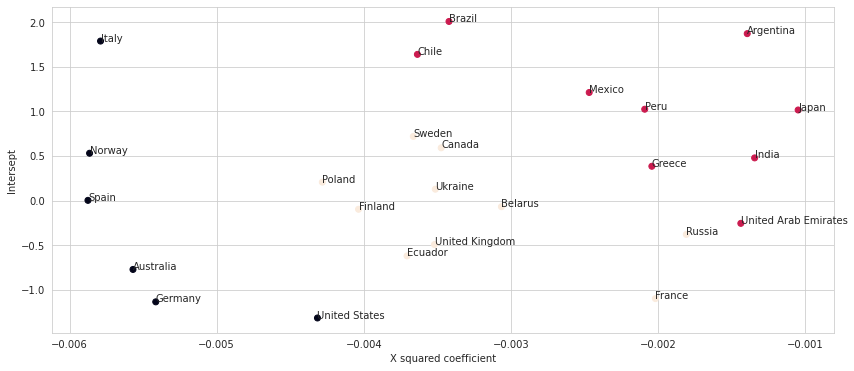

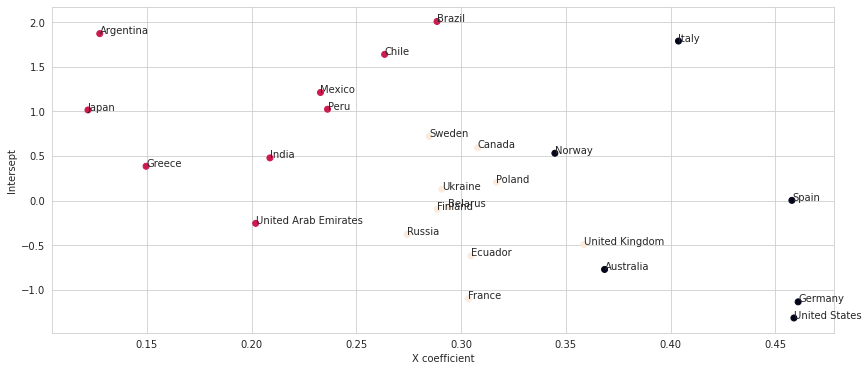

In [31]:
# clusters visualization
plt.scatter(coefs['x_sq_coef'], coefs['x_coef'], c=coefs.cluster.values)
for c, xs, x in zip(coefs['country'], coefs['x_sq_coef'], coefs['x_coef']):
    plt.annotate(c, (xs, x))
plt.ylabel('X coefficient')
plt.xlabel('X squared coefficient')
plt.legend()
plt.show()

plt.scatter(coefs['x_sq_coef'], coefs['intersept'], c=coefs.cluster.values)
for c, xs, x in zip(coefs['country'], coefs['x_sq_coef'], coefs['intersept']):
    plt.annotate(c, (xs, x))
plt.ylabel('Intersept')
plt.xlabel('X squared coefficient')
plt.show()

plt.scatter(coefs['x_coef'], coefs['intersept'], c=coefs.cluster.values)
for c, xs, x in zip(coefs['country'], coefs['x_coef'], coefs['intersept']):
    plt.annotate(c, (xs, x))
plt.ylabel('Intersept')
plt.xlabel('X coefficient')
plt.show()

5. [Эта часть задания не оценивается, здесь нет правильных и неправильных
ответов, но буду рад узнать, что вы думаете]

Что вы поняли из этого упражнения? Что можно сказать про коронавирус по итогам
такого моделирования? Как принять решение, например, о том, нужно ли вводить
карантин?

It is seen that in some countries it's really good fit to approximate with sin. Still, it doesn't take into account any seasonality: there where several COVID waves in cold and flu seasons. Anyway, predicting with sin is better (and much more optimistic) than with exponent, because the last one never ends and the population is limited.

I think it could be interesting to model different variant's waves within one country. Unfortunately, the source has only info about overall COVID cases, so it's not feasible.

New cases rose dramatically with time in Ukraine, United States, Chile, Mexico, Brazil, Argentina, India, Peru. Here the prediction with sin would be inaccurate. Maybe if taken not days but weeks data the model would work better.

To make all analysis with the same approach I fixed train size as 50 first days. Still, this parameter should differ from country to country because spread rates are different (country could be dencly populated or not, with lots of people mobility or not, COVID consious or not and so on). This led to a situation, when for the first 50 days epidemic could range from 'just began' to 'almost ended'. Also, data is collected in various ways: some countries have high week seasonality (I tried smoothed data, results differed not much), missing data or started COVID tracking late when COVID cases where already high. Different countries can have various 'hidden COVID rate' - when people are sick but not tested and not aware of it (or test results are pending for a long time). Sometimes the data is missleading - spikes in France and Ecuador cases are just cumulative cases from earlier days.

**Cluster 0** countries tend to have wider peak then it was predicted - the situation when COVID cases don't peak and go down but stay on the peak level for some time and then change. This is the situation in between of rather 'light COVID for a country' and the time when 'the situation goes out of control'. I'd recommend for this cluster to **have some quarantine measures**.

**Cluster 1** countries tend to have the **COVID peak passed** during the train (first 50 days). Sometimes it's connected with the COVID rapid growth or simply late COVID cases identification (for example Norway). This cluster **doesn't need strict quarantine measures** because the alpha variant is almost over for these countries. Or this could mean that a country had quarantine measures that where really successful.

**Cluster 2** countries tend to have COVID cases increase significantly in test. The further situation went out of control. This cluster **needed strict quarantine measures**. It's really interesting how we were able to predict it in the beginning!

### References
Hannah Ritchie, Edouard Mathieu, Lucas Rodés-Guirao, Cameron Appel, Charlie Giattino, Esteban Ortiz-Ospina, Joe Hasell, Bobbie Macdonald, Diana Beltekian and Max Roser (2020) - "Coronavirus Pandemic (COVID-19)". Published online at OurWorldInData.org. Retrieved from: 'https://ourworldindata.org/coronavirus' [Online Resource]